In [1]:
pip install -U albumentations

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
pip uninstall opencv-python-headless==4.5.5.62y

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [3]:
pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.4 MB/s 


In [32]:

from torch.utils.data import Dataset, DataLoader
from pandas.core.common import flatten

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision import datasets, transforms, utils
import cv2
import glob
import numpy as np
import random


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]

###Downloading and unzipping iNaturalist Dataset

In [5]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2022-03-23 13:16:21--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   181MB/s    in 23s     

2022-03-23 13:16:43 (161 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
!unzip "/content/nature_12K.zip"

######################
#               Define Transforms
######################

In [21]:
transform = transforms.Compose([transforms.Resize((255, 255)),
                                 transforms.ToTensor()])

################################################
#       Create Train, Valid and Test sets
################################################

In [41]:
train_data_path = '/content/inaturalist_12K/train' 
test_data_path = '/content/inaturalist_12K/val'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values


# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

# split train valid from train paths (80,20)
train_image_paths, val_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(val_image_paths), len(test_image_paths)))


train_image_path example:  /content/inaturalist_12K/train/Mollusca/347158f1001d0f250ca73b19f058df14.jpg
class example:  Insecta
Train size: 7999
Valid size: 2000
Test size: 2000


#########################################
#      Create dictionary for class indexes
#########################################

In [9]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

############################
#               Define Dataset Class
############################


In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [42]:
from PIL import Image
class INaturalist(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath).convert('RGB')
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

###########################
#                  Create Dataset
###########################

In [43]:
train_dataset = INaturalist(train_image_paths, transform)
val_dataset = INaturalist(val_image_paths, transform)
test_dataset = INaturalist(test_image_paths, transform)

In [20]:
train_dataset

In [44]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 255, 255])
The label for 50th image in train dataset:  4


#######################
#                  Define Dataloaders
#######################

In [45]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [30]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

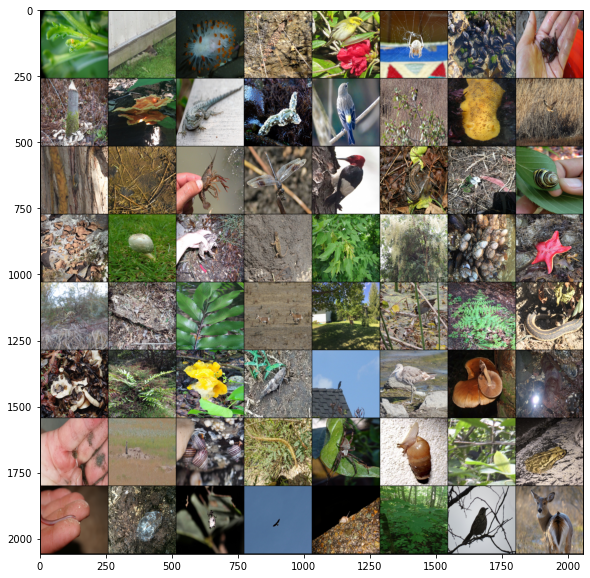

GroundTruth:  Plantae Mammalia Mollusca Reptilia


In [33]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [46]:
for i,data in enumerate(train_loader):
  print(data[0].shape)

torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size([64, 3, 255, 255])
torch.Size